# Figure 3. Longitudinal effect of age on the excitation-inhibition ratio during adolescence

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
import sklearn.utils
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data:

In [3]:
itMax = 81
lmbda = 210
params = {
    "G": "0.5-4",
    "wee": "0.05-0.75",
    "wei": "0.05-0.75",
    "wie": "0",
}
het_params = "wee-wei"
n_vols_remove = 13  # ~ 30s: int(30 / 2.2)

elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "imagen_subs_FU2.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels("schaefer-100")

In [4]:
if os.path.exists("imagen_fc-ses_sc-FU2_runs-2.csv") & os.path.exists(
    "imagen_fc-ses_sc-FU2_runs-2_vars.pkz"
):
    subjects_optima = pd.read_csv("imagen_fc-ses_sc-FU2_runs-2.csv", index_col=0)
    with open("imagen_fc-ses_sc-FU2_runs-2_vars.pkz", "rb") as f:
        regional_vars = pickle.load(f)
else:
    subjects_optima = []
    regional_vars = {}
    for sub in tqdm(elig_subs.index):
        regional_vars[sub] = {}
        for ses in ["BL", "FU2"]:
            cmaes_dir = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "sim",
                sub,
                "sc-FU2_ctx_parc-schaefer-100_mean001_thresh-1",
                "6maps_schaefer-100_zscore",
                "cmaes_multimaps_gpu",
            )
            sims_dir = cmaes_dir.replace("cmaes_multimaps_gpu", "sims_multimaps_gpu")
            sc_path = os.path.join(
                OUTPUT_DIR["imagen"],
                "FU2",
                "SC",
                sub,
                "ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.txt",
            )
            emp_fc_tril_path = os.path.join(
                OUTPUT_DIR["imagen"],
                ses,
                "FC",
                sub,
                "ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCtril.txt",
            )
            emp_fcd_tril_path = emp_fc_tril_path.replace("FCtril", "FCDtril")
            emp_fc_tril = np.loadtxt(emp_fc_tril_path)
            emp_fcd_tril = np.loadtxt(emp_fcd_tril_path)
            regional_vars[sub][ses] = {}
            for SeedMW in [1, 2]:
                cmaes_res = load_cmaes(
                    cmaes_dir,
                    sims_dir,
                    params,
                    het_params,
                    emp_fc_tril,
                    emp_fcd_tril,
                    sc_path=sc_path,
                    n_vols_remove=n_vols_remove,
                    itMax=itMax,
                    lmbda=lmbda,
                    SeedMW=SeedMW,
                    dataset="imagen",
                )
                if cmaes_res:
                    cmaes_res[0]["sub"] = sub
                    cmaes_res[0]["ses"] = ses
                    cmaes_res[0]["SeedMW"] = SeedMW
                    subjects_optima.append(cmaes_res[0])
                    regional_vars[sub][ses][SeedMW] = cmaes_res[1]
    subjects_optima = pd.DataFrame(subjects_optima)
    subjects_optima.to_csv("imagen_fc-ses_sc-FU2_runs-2.csv")
    with open("imagen_fc-ses_sc-FU2_runs-2_vars.pkz", "wb") as f:
        pickle.dump(regional_vars, f)

Select the best run in each subject-session and add the demographics and motion measures to the data:

In [5]:
subjects_optima[["sex", "site"]] = elig_subs.loc[
    subjects_optima.set_index("sub").index, ["sex", "recruitment centre"]
].values
best_runs = subjects_optima.groupby(["sub", "ses"])["gof"].idxmax().values
data = subjects_optima.loc[best_runs]
data.loc[data["ses"] == "BL", "age"] = elig_subs.loc[
    data.loc[data["ses"] == "BL", "sub"].values, "age_BL"
].values
data.loc[data["ses"] == "FU2", "age"] = elig_subs.loc[
    data.loc[data["ses"] == "FU2", "sub"].values, "age_FU2"
].values
data = data.set_index(["sub", "ses"])

# add motion data
motion_BL = pd.read_csv(
    os.path.join(OUTPUT_DIR["imagen"], "BL", "postfmriprep", "participants.tsv"),
    delimiter="\t",
)
motion_BL["ses"] = "BL"
motion_FU2 = pd.read_csv(
    os.path.join(OUTPUT_DIR["imagen"], "FU2", "postfmriprep", "participants.tsv"),
    delimiter="\t",
)
motion_FU2["ses"] = "FU2"
motion = pd.concat([motion_BL, motion_FU2]).rename(columns={"participant_label": "sub"})
motion = motion.set_index(["sub", "ses"]).loc[data.index]
data = pd.concat([data, motion], axis=1)

In [6]:
data.to_csv("imagen_fc-ses_sc-FU2_runs-2_data.csv")

Create a dataframe of regional $\langle I^E \rangle$ in each subject

In [7]:
I_E = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for idx, row in data.iterrows():
        sub = idx[0]
        ses = idx[1]
        I_E.loc[idx, parc] = regional_vars[sub][ses][row["SeedMW"]].loc[i, "I_E"]
I_E.to_csv("imagen_fc-ses_sc-FU2_runs-2_IE.csv")

Apply the linear mixed effects model:

In [8]:
df = pd.concat([I_E, data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
d_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)

for i, parc in tqdm(enumerate(parcels)):
    # exclude outliers
    curr_subs_BL = (
        I_E.loc[(slice(None), ["BL"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["BL"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs_FU2 = (
        I_E.loc[(slice(None), ["FU2"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["FU2"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
    model_df = df.loc[(curr_subs, slice(None))].reset_index(drop=False)
    # calculate standardized mean difference of I_E resid as a variant of Cohen's d
    res_conf = smf.mixedlm(
        f"node_{i} ~ gof + sex + mean_rms + site", data=model_df, groups=model_df["sub"]
    ).fit()
    model_df["resid"] = res_conf.resid
    resid_diff = (
        model_df.loc[model_df["ses"] == "FU2", "resid"].values
        - model_df.loc[model_df["ses"] == "BL", "resid"].values
    )
    d_age.loc[parc] = resid_diff.mean() / resid_diff.std(ddof=1)
    # fit the main model
    mod = smf.mixedlm(
        f"node_{i} ~ age + gof + sex + mean_rms + site",
        data=model_df,
        groups=model_df["sub"],
    )
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "d": d_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age.to_csv("p_imagen_fc-ses_sc-FU2_runs-2_IE_age_stats.csv")
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

100it [00:50,  1.97it/s]


,t,d,p,p_fdr
7Networks_LH_Cont_pCun_1,-3.981,-0.298,0.000,0.005
7Networks_LH_Vis_1,-3.784,-0.299,0.000,0.005
7Networks_LH_Cont_Par_1,-3.758,-0.272,0.000,0.005
7Networks_LH_DorsAttn_Post_5,-3.695,-0.290,0.000,0.005
7Networks_RH_DorsAttn_Post_3,-3.677,-0.284,0.000,0.005
7Networks_LH_SalVentAttn_Med_2,-3.591,-0.264,0.000,0.005
7Networks_RH_DorsAttn_Post_1,-3.548,-0.272,0.000,0.005
7Networks_LH_Default_pCunPCC_2,-3.544,-0.265,0.000,0.005
7Networks_RH_Cont_Par_1,-3.521,-0.267,0.000,0.005
7Networks_LH_DorsAttn_Post_3,-3.475,-0.260,0.001,0.005


## A. Effect of age on E-I ratio (FDR-corrected)

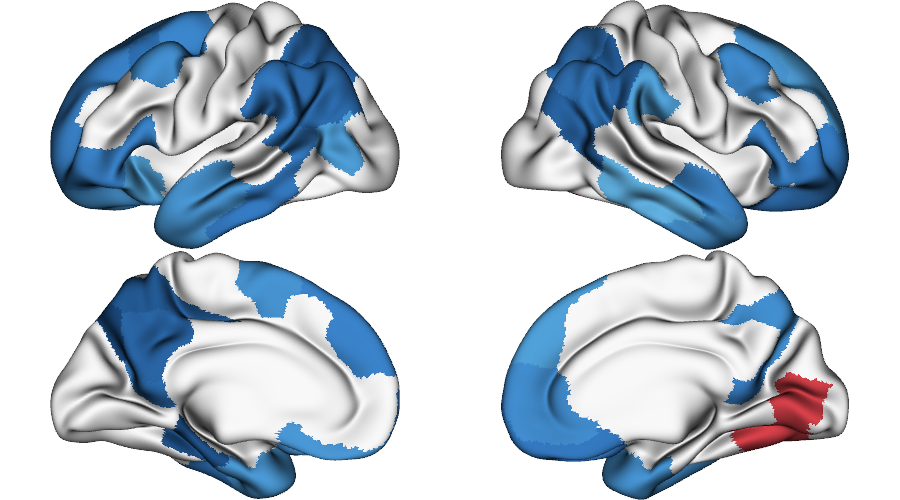

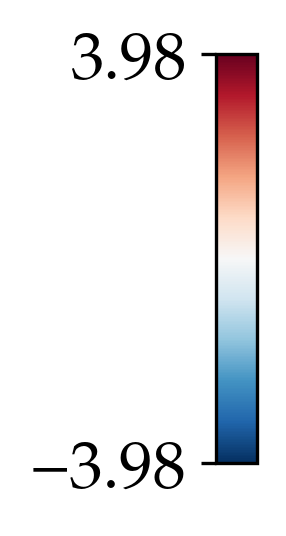

In [9]:
vmin = min(t_age.values.min(), -t_age.values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        t_age[p_age_fdr < 0.05], "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style="grid",
    # filename='./figures/3A.svg'
)

## B. Effect of age on E-I ratio (unthresholded)

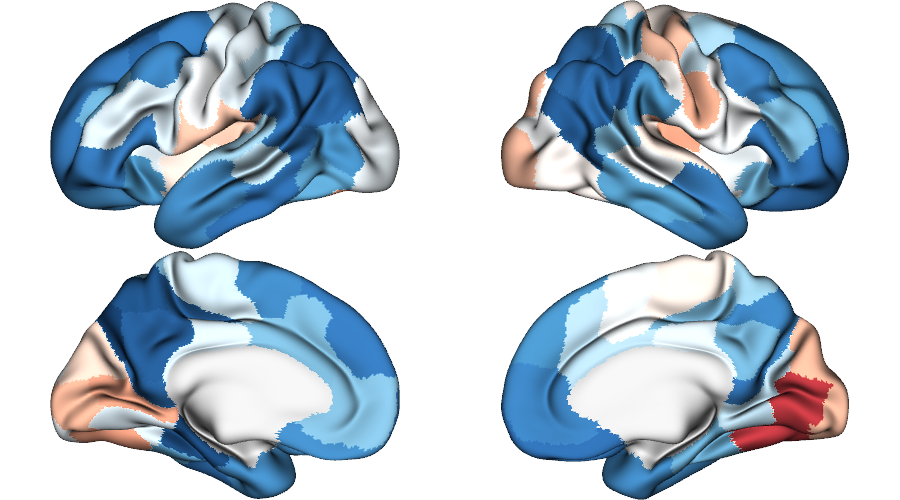

In [10]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange=(vmin, vmax),
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
    # filename='./figures/3B.svg'
)

## C. Stability of age effect map across subsamples of subjects

Calculate age effects in 100 half-split subsamples of subjects:

In [11]:
n_subsamples = 100
n_samples = elig_subs.shape[0] // 2
print("Using n_samples", n_samples)

t_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)
p_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)

for subsample in tqdm(range(n_subsamples)):
    # creating half-split subsamples without replacement
    # stratified by sex and site
    # using subsample index as random_state for reproducibility
    subsample_subs = sklearn.utils.resample(
        elig_subs,
        replace=False,
        n_samples=n_samples,
        random_state=subsample,
        stratify=elig_subs[["sex", "recruitment centre"]],
    )
    subsample_df = df.loc[(subsample_subs.index, slice(None))]
    for i, parc in enumerate(parcels):
        # exclude outliers
        curr_subs = subsample_subs.loc[
            ~(scipy.stats.zscore(subsample_df.loc[:, f"node_{i}"]).abs() >= 3)
            .reset_index()
            .groupby("sub")[f"node_{i}"]
            .any()
        ].index
        model_df = subsample_df.loc[(curr_subs, slice(None))].reset_index(drop=False)
        # fit the model
        mod = smf.mixedlm(
            f"node_{i} ~ age + gof + sex + mean_rms + site",
            data=model_df,
            groups=model_df["sub"],
        )
        res = mod.fit()
        t_subsamples.loc[parc, subsample] = res.tvalues["age"]
        p_subsamples.loc[parc, subsample] = res.pvalues["age"]

Using n_samples 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [36:41<00:00, 22.02s/it]


Calculate spatial correlation of E-I ratio age effects between all pairs of subsamples:

In [12]:
subsamples_corr = np.corrcoef(t_subsamples.values.T)
subsamples_corr = subsamples_corr[np.tril_indices_from(subsamples_corr, -1)]

Plot the distribution of correlations:

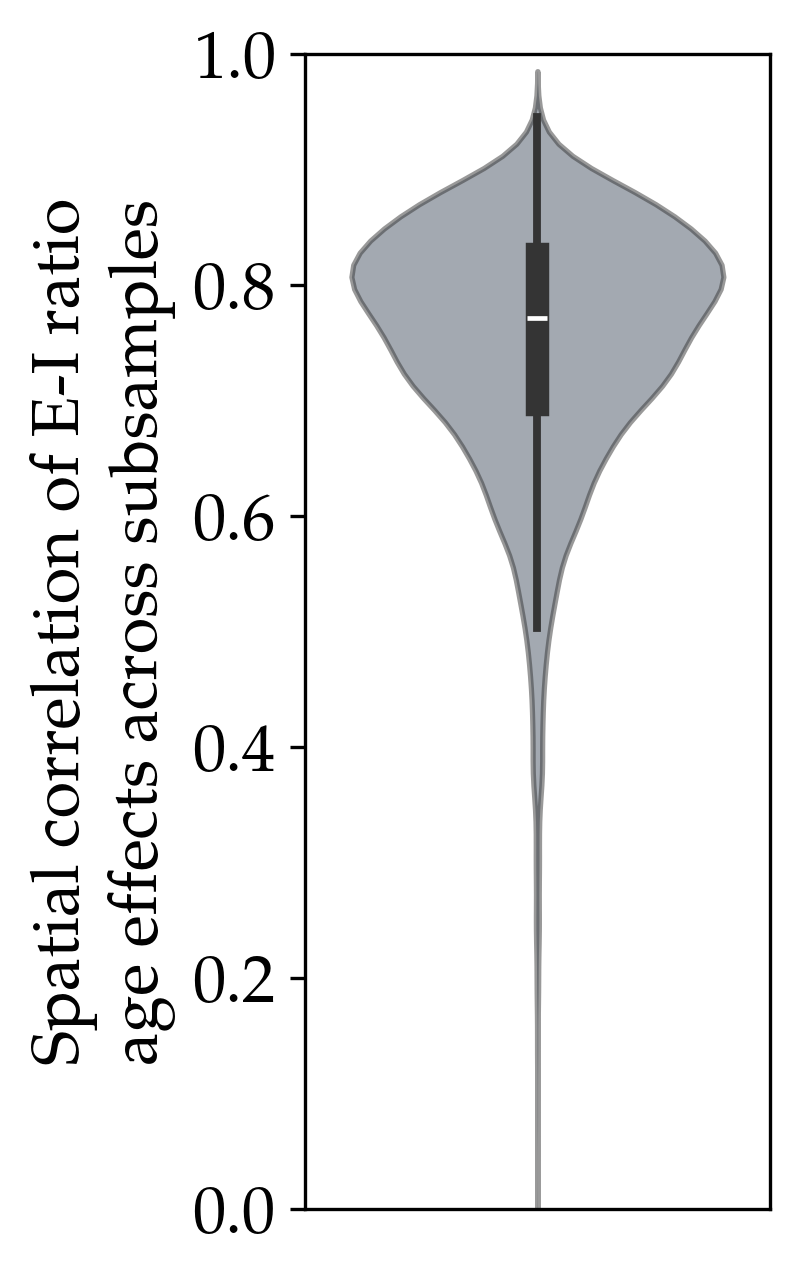

In [13]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.violinplot(y=subsamples_corr, color=thcolor, inner='box', alpha=0.5, ax=ax)
ax.set_ylabel(
    "Spatial correlation of E-I ratio\nage effects across subsamples"
)
ax.set_ylim([0, 1])
ax.set_xticks([])
# fig.savefig('./figures/3C.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

In [16]:
pd.Series(subsamples_corr).describe()

count    4950.000000
mean        0.749599
std         0.107783
min        -0.012969
25%         0.696859
50%         0.770886
75%         0.826283
max         0.945709
dtype: float64

## D. Conjunction of significant regions from PNC and IMAGEN

In [11]:
stats_age_pnc = pd.read_csv("p_pnc_fc-sub_sc-sub_runs-2_IE_age_stats.csv", index_col=0)
stats_age_imagen = pd.read_csv("p_imagen_fc-ses_sc-FU2_runs-2_IE_age_stats.csv", index_col=0)

conj = (stats_age_pnc["p_fdr"] < 0.05) & (stats_age_imagen["p_fdr"] < 0.05)
conj_t = pd.DataFrame({"pnc": stats_age_pnc["t"], "imagen": stats_age_imagen["t"]}).loc[
    conj
]
conj_t.describe()

,pnc,imagen
count,33.000000,33.000000
mean,-4.466251,-3.175966
std,1.333693,0.361488
min,-7.329795,-3.981309
25%,-5.143936,-3.420748
50%,-4.458318,-3.169074
75%,-3.272985,-2.936594
max,-2.370438,-2.532283


Conjunction does not include increases, therefore let's plot the conjunction parcels as a mask of blues:

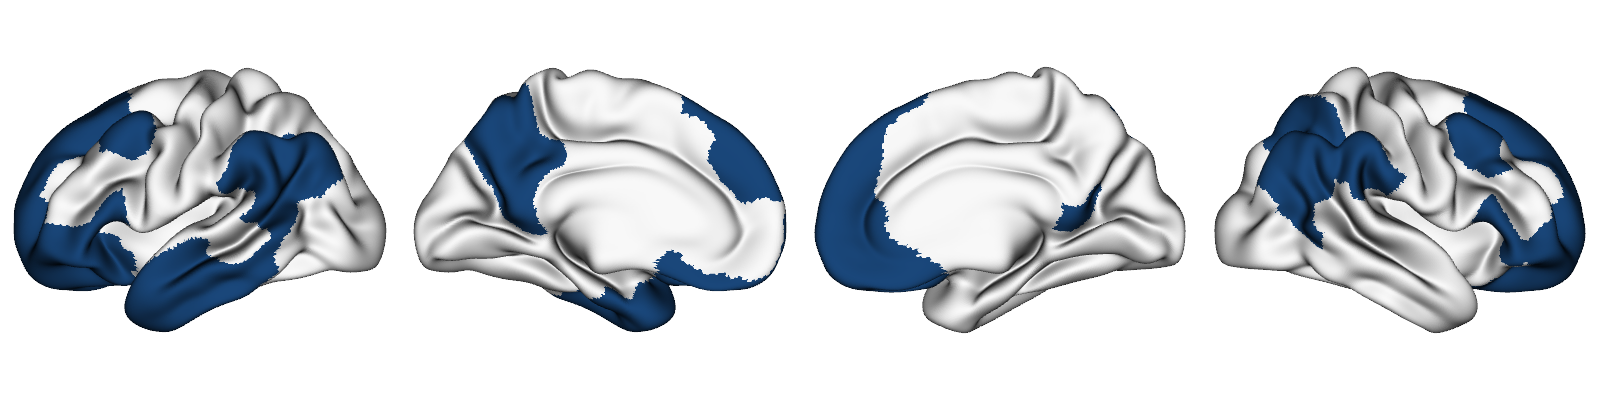

In [12]:
plot.plot_surface(
    transform.deparcellate_surf(
        (conj_t.iloc[:, 0] < 0).astype("int"),
        "schaefer-100",
        concat=True,
        space="fsaverage",
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu",
    cbar=False,
    layout_style="row",
    # filename='./figures/3D.svg'
)

## E. Correlation with PNC age effects

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.6298358487391693 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.7822041217721956 ; p-vlaue: 0.0


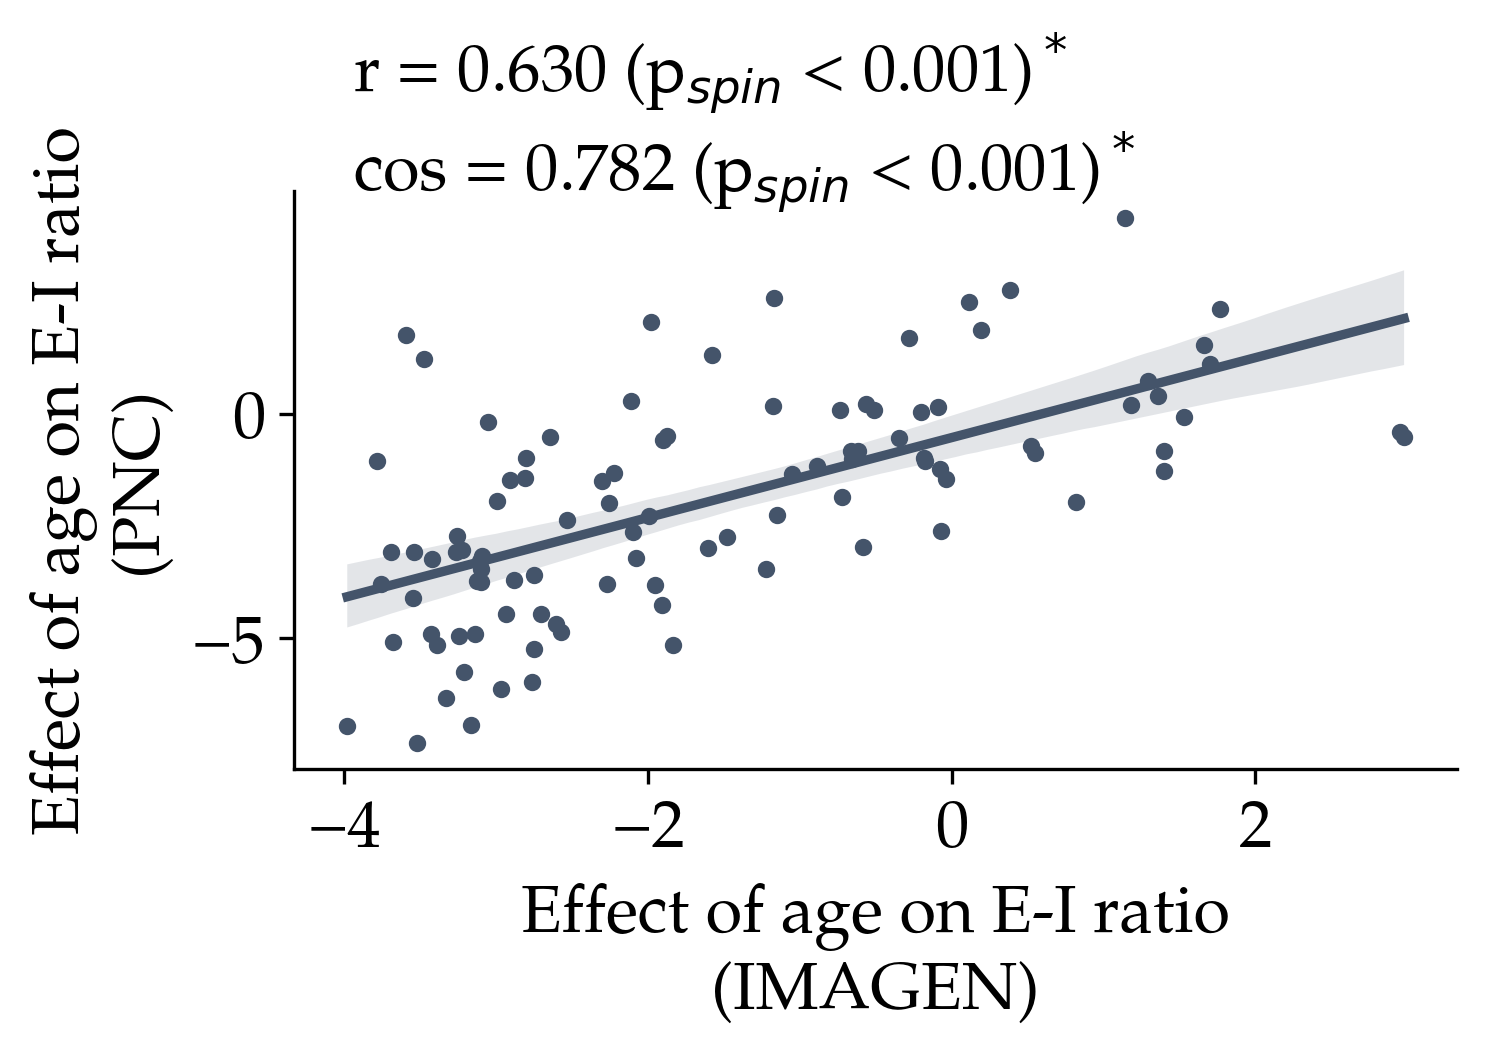

In [17]:
fig, ax = plt.subplots(figsize=(5, 2.5))
plot.reg_plot(
    stats_age_imagen[["t"]], stats_age_pnc[["t"]], "schaefer-100", n_perm=1000, 
    xlabel="Effect of age on E-I ratio\n(IMAGEN)",
    ylabel="Effect of age on E-I ratio\n(PNC)",
    ax=ax
)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
# fig.savefig('./figures/3E.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

## Text. Age-by-sex intercation

In [23]:
t_age_sex = pd.Series(index=parcels, dtype=float)
p_age_sex = pd.Series(index=parcels, dtype=float)
for i, parc in tqdm(enumerate(parcels)):
    # exclude outliers
    curr_subs_BL = (
        I_E.loc[(slice(None), ["BL"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["BL"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs_FU2 = (
        I_E.loc[(slice(None), ["FU2"]), parc]
        .loc[~(scipy.stats.zscore(I_E.loc[(slice(None), ["FU2"]), parc]).abs() >= 3)]
        .index.get_level_values(0)
    )
    curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
    model_df = df.loc[(curr_subs, slice(None))].reset_index(drop=False)
    mod = smf.mixedlm(
        f"node_{i} ~ age*sex + gof + mean_rms + site",
        data=model_df,
        groups=model_df["sub"],
    )
    res = mod.fit()
    t_age_sex.loc[parc] = res.tvalues["age:sex[T.M]"]
    p_age_sex.loc[parc] = res.pvalues["age:sex[T.M]"]

# FDR correction
_, p_age_sex_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_sex)
p_age_sex_fdr = pd.Series(p_age_sex_fdr, index=parcels)

# display effect of signficant regions
t_age_sex[p_age_sex_fdr < 0.05].sort_values()

100it [00:17,  5.59it/s]


Series([], dtype: float64)